<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/burn_severity/GetData_NISAR_Simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading NISAR Simulated Data (from UAVSAR) & Making GIS-Ready Products**

*This notebook runs through downloading and pre-processing NISAR Simulated Data to be used for fire severity analysis over the Verdugo Mountains in Los Angeles*

- Inputs: GRD, INC, and Annotation files
- Outputs: Masked, cropped, incidence-angle correction, speckle filtered, geotiffs

----------------

Table of Contents:
0. [Running the Notebook](#s1)
1. [Download UAVSAR Data](#s2)
2. [Generate a HDR File](#s3)
3. [Read in data and plot](#s4)
4. [Crop and export to geotiff](#s5)

<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

In [1]:
!pip install rasterio --quiet        # Install python package "rasterio" into Google Colab environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.2 MB/s eta 0:00:00


In [151]:
# Scripts and functions needed from GitHub repos
# To build HDR files
!git clone https://bitbucket.org/nathanmthomas/bucket-of-rs-and-gis-scripts/src/master/BuildUAVSARhdr.py

# To appy Enhanced Lee Speckle Filter
!git clone https://github.com/NaiaraSPinto/VegMapper.git

# To generate geotiffs and apply incidence angle masking
!wget https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py

fatal: destination path 'BuildUAVSARhdr.py' already exists and is not an empty directory.
fatal: destination path 'VegMapper' already exists and is not an empty directory.
--2024-05-15 16:17:24--  https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5783 (5.6K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]   5.65K  --.-KB/s    in 0s      

2024-05-15 16:17:24 (45.2 MB/s) - ‘functions.py’ saved [5783/5783]



In [152]:
import rasterio as rio               # Reading and writing raster formats
import numpy as np                   # Numeric and mathematic functions
import matplotlib.pyplot as plt      # Plotting, making graphs
import getpass                       # Discreet way to enter username and password
import os
from osgeo import gdal
from skimage import filters          # For otsu thresholding
import math
import geopandas as gpd
from matplotlib.patches import Patch          # Creates and plots visualization i.e. legends or figures - (Section 3, 4)
from rasterio.plot import plotting_extent     # Creates an object to plot raster and vector data together - (Section 3. HV Change Detection)
import requests
from osgeo import gdal
from rasterio.plot import show_hist
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
from rasterio.plot import show

# Read in functions from functions.py script
from functions import * #download_files, process_grd_files, process_inc_files, mask_and_save, convert_db

# Read in enhanced lee filter from VegMapper
import sys
path_to_module = '/content/VegMapper/vegmapper/core/'
sys.path.append(path_to_module)
from filter import enhanced_lee

<a name="s2"></a>
# 1. Download UAVSAR and NISAR Simulated Data

An Earthdata account is required to download the UAVSAR or NISAR Simulated data stored at ASF to this notebook environment. Create an account here, if needed: https://urs.earthdata.nasa.gov//users/new

In [4]:
username = getpass.getpass(prompt='Earthdata username:')
password = getpass.getpass(prompt='Earthdata password:')

Earthdata username:··········
Earthdata password:··········


Now, download the UAVSAR data and its corresponding annotation file using wget and your Earthdata username and password. The annotation file (.ann) is required to generate a HDR (.hdr) file. This hdr file stores the georeferencing information of an associated raw raster file and is needed to make the UAVSAR GRD files (.grd) GIS-readable.


Browse for UAVSAR data of interest here: https://uavsar.jpl.nasa.gov/cgi-bin/data.pl

* To download here, replace the links below with the new data of interest

In [23]:
# NISAR Simulated GRDs and corresponding annotation files
nisar_simulated_urls = [
    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090_CG_138A_02.ann",
    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090_CG_138A_02.ann",

    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090HHHH_CG_138A_02.grd",

    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090_CG_138A_02.ann",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090_CG_138A_02.ann",

    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090HHHH_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090HHHH_CG_138A_02.grd"
]

destination_directory = "./"

download_files(nisar_simulated_urls, destination_directory, username, password)

# can also download one at a time with wget:
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_08525_14158_003_141023_L090_CX_01/SanAnd_08525_14158_003_141023_L090HVHV_CX_01.grd

Downloaded: SanAnd_08525_14158_003_141023_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_08525_17122_003_171102_L090_CG_138A_02.ann
Downloaded: SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_17122_004_171102_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_17122_003_171102_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_26526_17122_004_171102_L090HHHH_CG_138A_02.grd


In [6]:
# Download incidence angle files
# NISAR Simulated products do not have their own generated indicence angle files - will need to find the *.inc files from the corresponding UAVSAR data lines

destination_directory = "./"

# Incidence Angle Files for each line
inc_urls = [
    "https://uavsar.asf.alaska.edu/UA_SanAnd_26526_17122_004_171102_L090_CX_01/SanAnd_26526_17122_004_171102_L090_CX_01.inc",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_08525_23008_011_230712_L090_CX_01/SanAnd_08525_17122_003_171102_L090_CX_01.inc",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_26526_17122_004_171102_L090_CX_01/SanAnd_26526_17122_004_171102_L090_CX_01.ann",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_08525_23008_011_230712_L090_CX_01/SanAnd_08525_17122_003_171102_L090_CX_01.ann"

]

download_files(inc_urls, destination_directory, username, password)

Failed to download: SanAnd_26526_17122_004_171102_L090_CX_01.inc, Status code: 401
Failed to download: SanAnd_08525_17122_003_171102_L090_CX_01.inc, Status code: 401


Using ASF search instead
* Download reference: https://github.com/asfadmin/Discovery-asf_search/blob/master/examples/5-Download.ipynb

In [8]:
## Using ASF Search
!pip install asf_search --quiet

In [12]:
import asf_search as asf
session = asf.ASFSession() # Downloading requires session

import getpass
username = input('Username:')
password = getpass.getpass('Password:')

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Username:annemariepeacock
Password:··········
Success!


In [31]:
granule_list = [
    'UA_SanAnd_26526_17122_004_171102_L090_CX_01-INC',
    'UA_SanAnd_08525_17122_003_171102_L090_CX_01-INC',
    'UA_SanAnd_26526_17122_004_171102_L090_CX_01-METADATA',
    'UA_SanAnd_08525_17122_003_171102_L090_CX_01-METADATA',
]
results = asf.granule_search(granule_list=granule_list)

print(f'{len(results)} results found')

4 results found


In [32]:
results.download(path='./', session=user_pass_session, processes=4)

/usr/local/lib/python3.10/dist-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: ./SanAnd_26526_17122_004_171102_L090_CX_01.inc
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/usr/local/lib/python3.10/dist-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: ./SanAnd_08525_17122_003_171102_L090_CX_01.inc
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')


In [21]:
# urls = [
#     'https://uavsar.asf.alaska.edu/UA_SanAnd_26526_17122_004_171102_L090_CX_01/SanAnd_26526_17122_004_171102_L090_CX_01.inc',
#     'https://uavsar.asf.alaska.edu/UA_SanAnd_08525_23008_011_230712_L090_CX_01/SanAnd_08525_17122_003_171102_L090_CX_01.inc']

# asf.download_urls(urls=urls, path='./', session=user_pass_session, processes=2)

<a name="s3"></a>
# 2. Generate a HDR file

Generate HDR files for each of the GRDs, so they can be GIS-compatible and converted to geotiffs.

In [24]:
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -h

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

usage: BuildUAVSARhdr.py [-h] [-i INPUT] [-r UAVSAR] [-p POLARIZATION]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Specify the input UAVSAR ann file
  -r UAVSAR, --uavsar UAVSAR
                        Specify the input UAVSAR radar file
  -p POLARIZATION, --polarization POLARIZATION
                        Specify the input UAVSAR polarization in UPPERCASE (i.e HHHV, HHHH, VVVV,
                        AMP1, AMP2, COR, UNW, HGT, INT)


In [33]:
def run_hdr_script(directory, polarization):
    file_data = []

    # Find GRD and annotation files
    for filename in os.listdir(directory):
        if filename.endswith('.grd'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.grd', '.ann')
            file_data.append((grd_file, annotation_file))
        elif filename.endswith('.inc'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.inc', '.ann')
            file_data.append((grd_file, annotation_file))

    # Run HDR script for each file
    for grd_file, annotation_file in file_data:
        !python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {grd_file} -p {polarization}

# Run HDR script for HVHV polarization
run_hdr_script('./', 'HVHV')

# Run HDR script for HHHH polarization
run_hdr_script('./', 'HHHH')

# Run HDR script for incidence angle files (assuming .inc files)
run_hdr_script('./', 'HVHV')  # You can put whichever polarization, using HVHV as a placeholder here

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

UPPER LEFT LAT =  34.557
UPPER LEFT LONG =  -119.3376
SAMPLES = 5126
Lines = 32833
PIXEL SIZE =  0.0001
DATATYPE =  4
SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd.hdr
Writing output HDR file...
Output HDR file = SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd.hdr

Thank you for using UAVSAR.py

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and requir

<a name="s5"></a>
# 4. Crop the data and export subset to geotiff

In [118]:
# Define input directory and output directory
input_directory = './' # Directory containing GRD and INC files
output_directory = './'  # Directory to save processed files

# Define extent and projection details
upper_left_x = 373624.5024220281047747
upper_left_y = 3780585.1359808142296970
lower_right_x = 387664.5024220281047747
lower_right_y = 3791835.1359808142296970
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)

projection = 'EPSG:26911' # reprojecting here to be in meters to match the Landsat data that will be reprojected in meters.

In [84]:
# Process GRD files
process_grd_files(input_directory, output_directory, window, projection)

In [154]:
process_inc_files

<function functions.process_inc_files(input_dir, output_dir, window=None, projection=None)>

In [155]:
reference_path = 'SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02_clipped.tif'
reference_info = gdal.Info(reference_path, format='json')
projection = reference_info['coordinateSystem']['wkt']
x_resolution = reference_info['geoTransform'][1]
y_resolution = abs(reference_info['geoTransform'][5])

# Process incidence angle files
process_inc_files(input_directory, output_directory, window, projection, x_resolution, y_resolution)

TypeError: process_inc_files() takes from 2 to 4 positional arguments but 6 were given

# 5. Incidence Angle Corrections/Masking

Converting sigma0 to gamma0 should remove most of the range/incidence angle dependency.

gamma0 = sigma0 / cos(incidence angle)

In [122]:
mask_and_save(input_directory, output_directory)

Over the Verdugo Mountains, UAVSAR collected data in opposing directions. We can merge this opposite heading lines to fill in masked data from low/high incidence angles.

In [130]:
## Pre-Fire
# Open the two input rasters using rasterio
with rio.open('SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_prefire = np.nanmax((arr1, arr2), axis=0)

## Post-Fire
# Open the two input rasters using rasterio
with rio.open('SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_postfire = np.nanmax((arr1, arr2), axis=0)

<ipython-input-130-86cb7504a88f>:12: RuntimeWarning: All-NaN axis encountered
  merged_arr_prefire = np.nanmax((arr1, arr2), axis=0)
<ipython-input-130-86cb7504a88f>:25: RuntimeWarning: All-NaN axis encountered
  merged_arr_postfire = np.nanmax((arr1, arr2), axis=0)


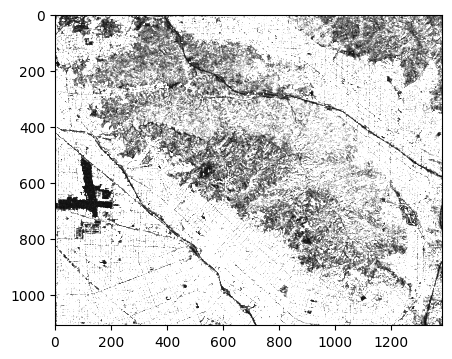

In [132]:
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(merged_arr_prefire, vmin=0, vmax=0.1, cmap="Greys_r")
plt.title('Pre-Fire merged opposing headings')

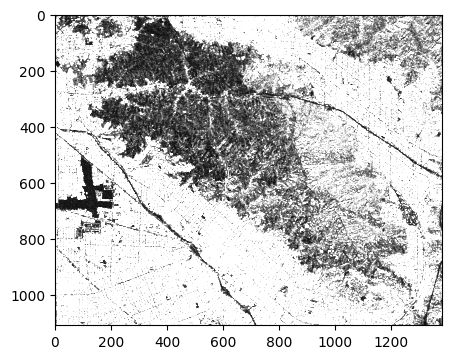

In [133]:
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(merged_arr_postfire, vmin=0, vmax=0.1, cmap="Greys_r")
plt.title('Post-Fire merged opposing headings')

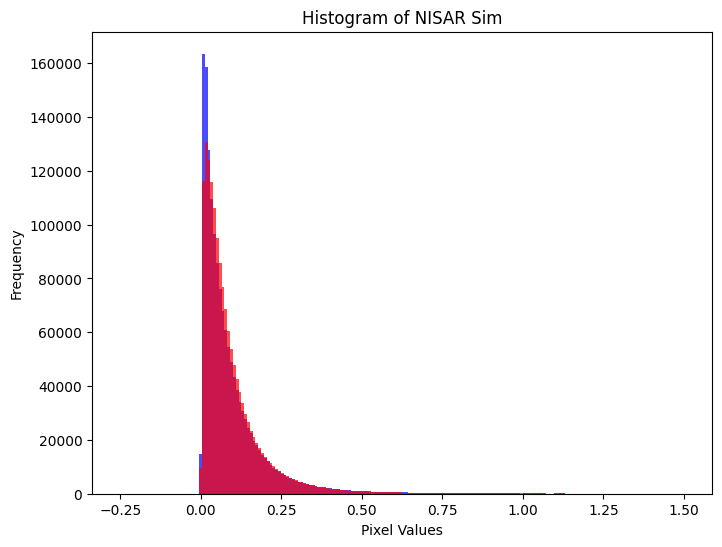

In [134]:
plt.figure(figsize=(3, 3))
plt.hist(merged_arr_postfire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='blue')
plt.hist(merged_arr_prefire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='red')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of NISAR Sim')
plt.show()

# Lee Filter

The NISAR simulated data has more speckle - use the modified lee filter for decrease data noise.

In [137]:
lee_merged_arr_prefire = enhanced_lee(merged_arr_prefire, 5, 1)
lee_merged_arr_postfire = enhanced_lee(merged_arr_postfire, 5, 1)

# Data Visualization

With the data already loaded in, can do some visualization and look at a fire severity classification (and export).

In [ ]:
#@title Plot HV Change Detection
# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
#HV_log_2014_2017 = np.log(np.divide(lee_merged_arr_2014, lee_merged_arr_2017))
# Find the HV ratio between 2014 and 2017 UAVSAR acquisitions
HV_2014_2017 = np.divide(lee_merged_arr_2014, lee_merged_arr_2017)
# Find the HV difference
HV_diff_2014_2017 = np.subtract(lee_merged_arr_2014, lee_merged_arr_2017)

fig, axs = plt.subplots(1,3,figsize=(30,10))
fig.suptitle('HV Change Detection')

HV_log = axs[0].imshow(HV_log_2014_2017, vmin=0, vmax=2)
fig.colorbar(HV_log, ax=axs[0], shrink=0.5)

HV_ratio = axs[1].imshow(HV_2014_2017, vmin=0, vmax=2)
fig.colorbar(HV_ratio, ax=axs[1], shrink=0.5)

HV_diff = axs[2].imshow(HV_diff_2014_2017, vmin=-0.005, vmax=0.05)
fig.colorbar(HV_diff, ax=axs[2], shrink=0.5)

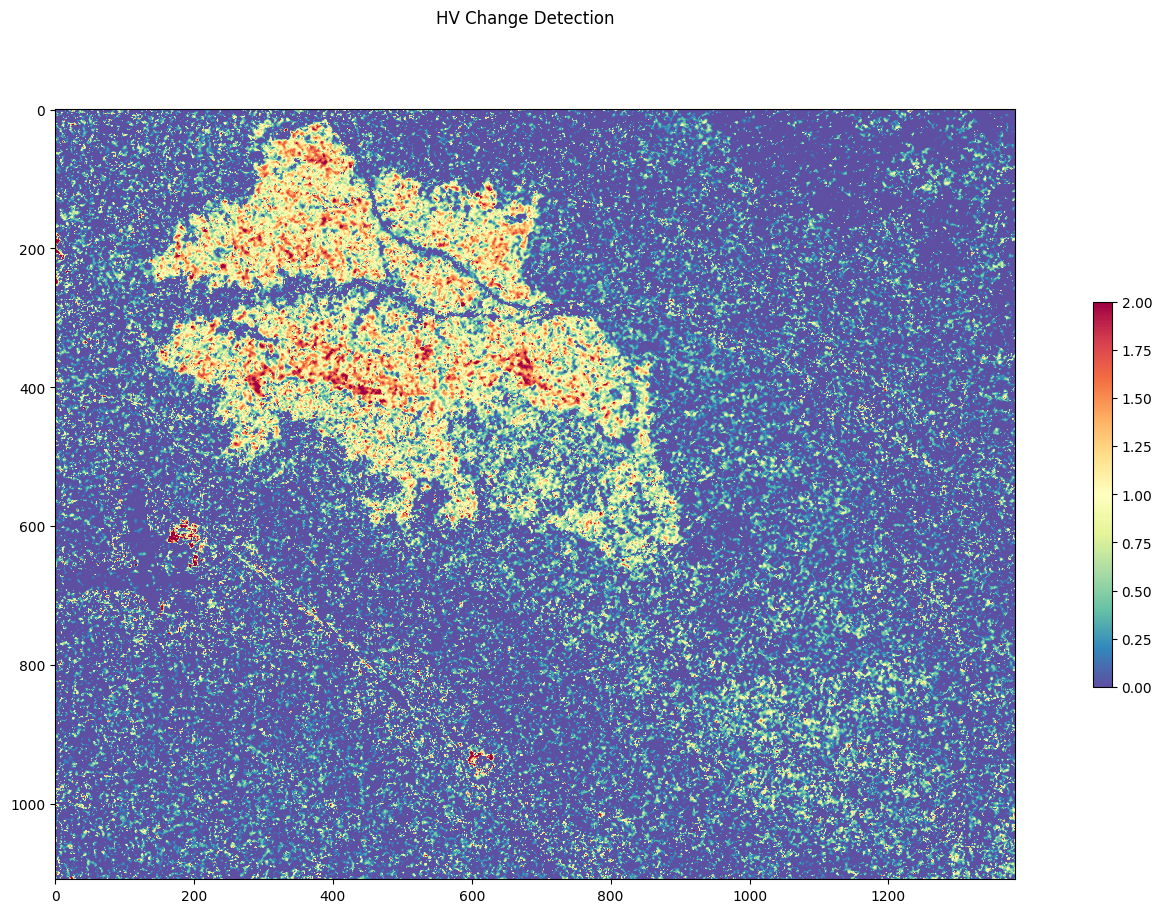

In [143]:
## HV log
HV_log = np.log(np.divide(lee_merged_arr_prefire, lee_merged_arr_postfire))

## HV log ratio in dB
#HV_log_dB = np.divide(convert_db(lee_merged_arr_prefire), convert_db(lee_merged_arr_postfire))

fig, axs = plt.subplots(figsize=(20,10))
fig.suptitle('HV Change Detection')

HV_log_plt = axs.imshow(HV_log, vmin=0, vmax=2, cmap="Spectral_r")
fig.colorbar(HV_log_plt, ax=axs, shrink=0.5)

In [ ]:
## histogram
plt.figure(figsize=(8, 6))
plt.hist(HV_log.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of NISAR Sim HV Log Ratio')
plt.show()

## thresholding?
# Extract cleaned array excluding NaN and infinity values
cleaned_array = out_image[~np.logical_or(np.isnan(out_image), np.isinf(out_image))]
# Perform Otsu's thresholding on the cleaned array
threshold_value = filters.threshold_otsu(cleaned_array)

HV_log = out_image.squeeze()
# Apply the threshold to the original array
thresholded_image = HV_log > threshold_value

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
axes[0].hist(cleaned_array.ravel(), bins=500, color='skyblue', alpha=0.7)
axes[0].axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value}')
axes[0].set_title('Value Histogram')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(-3, 3)  # Set x-axis limits
axes[0].legend()

# Plot the thresholded image
axes[1].imshow(thresholded_image, cmap='gray')
axes[1].set_title('Thresholded Image')

plt.tight_layout()
plt.show()

## classification?
from matplotlib.colors import ListedColormap  # For selecting colors that correspond to image pixels - (Section 5. Reclassify)
import matplotlib.colors as colors

# Separate into 4 classes depending on threshold
burn_thresh_hv = threshold_value
severity_thresh_hv = 1.8
hv = HV_log.copy()
hv_class = HV_log.copy()

#High Burn Severity UAVSAR (above high severity threshold)
hv_class[hv > severity_thresh_hv] = 30

# Moderate Burn Severity UAVSAR (above burned threshold and below high severity threshold)
hv_class[(hv < severity_thresh_hv) & (hv >= burn_thresh_hv)] = 20

# Unburned UAVSAR (below burned threshold)
hv_class[hv < burn_thresh_hv] = 10

# Remaining scenarios ignored
hv_class[hv_class < 10] = np.nan

# Define the colors you want
cmap = ListedColormap(["green", "yellow", "red"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
f, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hv_class, cmap = cmap)

import earthpy.plot as ep                     # Allows plotting of mapped raster/vector data -  (Section 5. Reclassify)
ep.draw_legend(im, titles=["Unburned", "Mod burn severity", "High burn severity"], classes=[10, 20, 30])

# Add general map title
plt.title("UAVSAR Fire Burn Severity Map")
plt.tight_layout()

## majority filtering?
## scipy options: https://enmap-box.readthedocs.io/en/latest/usr_section/usr_cookbook/generic_filter.html

# Export
- HV_log
- fire severity product
- send to UAVSAR staging area

In [ ]:
# Open the reference raster
with rio.open(reference_raster) as src:
    # Get metadata from the reference raster
    meta = src.meta

    # Update metadata to match the NumPy array
    meta.update({
        'dtype': HV_log.dtype,
        'count': 1  # Assuming there's only one band
    })

    # Write the NumPy array to a new GeoTIFF file
    with rio.open("HV_log_nisarsim.tif", 'w', **meta) as dst:
        dst.write(HV_log, 1)  # Assuming there's only one band (band index 1)